# Data Preparation

Modify the data so ML algorithms can properly learn from it.

The majority of reasons why we apply some of the changes are described in the data understanding notebook. If not, we explain it here.

### Imports

In [2]:
# Import necessary libraries, functions, objects...

import pandas as pd

### Load dataset

In [3]:
df = pd.read_csv('house_pricing.csv')

## Select Data

After the previous exploration you may decide to use or not use some of the data sets.

For this exercise there is **no decision to make, you use the only data set we have**.

## Clean Data

### Remove unnecessary features (if any)

In [4]:
# Drop useless features
df.drop(columns=['Electtrical', 'PoolArea', 'Utilities', 'Heating'], inplace=True)

### Deal with null or erroneous values (if any)

Ignore `MiscFeature` for now, we'll deal with it later in feature creation.

In [7]:
na_subs = {
    'Electrical': 'SBrkr',
    'GarageType': 'NoGarage',
    'GarageFinish': 'NoGarage',
    'GarageYrBlt': 0,  # Later create a boolean feature "HasGarage"
}
df.fillna(na_subs, inplace=True)

### Deal with duplicated rows that are errors (if any)

No important duplicates to remove.

### Decide what to do with outliers (if any)

Normally during this step you may decide to remove or change some outliers. However, **for this exercise do not remove any outliers**, leave them as they are.

## Construct Data

Decide if you want to create new features from the existing ones. You can be as creative as you want.

In [8]:
# Derive HasShed and remove Misc
df['HasShed'] = (~df['MiscFeature'].isna()).astype(int)
df.drop(columns='MiscFeature', inplace=True)

In [9]:
# Total SF for porch
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch']

# Total SF for constructions (GrLivArea should include all floors above ground)
df['BuiltArea'] = df['GrLivArea'] + df['TotalBsmtSF'] + df['TotalPorchSF'] + df['GarageArea']

# Ratio constructed / total area
df['BuiltAreaPerc'] = df['BuiltArea'] / df['LotArea']

# Ratio garage area
df['GaragePercArea'] = df['GarageArea'] / df['BuiltArea']

# Ratio garage area / cars
df['GarageCarsPerc'] = (df['GarageArea'] / df['GarageCars']).fillna(0)

In [10]:
# Check all GrLivArea >= sum of 1st and 2nd floors area
assert (df['GrLivArea'] >= df['1stFlrSF'] + df['2ndFlrSF']).all()

In [11]:
# Ratio 1st + 2nd floor surface / GrLivArea (maybe there is attic or similar?)
df['GrLivAreaPerc'] = (df['1stFlrSF'] + df['2ndFlrSF']) / df['GrLivArea']

In [12]:
# Check YearBuilt <= YearRemodAdd
assert (df['YearBuilt'] <= df['YearRemodAdd']).all()

In [13]:
# Create feature "has been remodeled" (it was not when year built is the same as remodeled)
df['WasRemod'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)

## Integrate Data

Decide if you want to integrate data from other sources.

**This is not needed for the exercises.**.

## Feature Engineering

### Encoding

Apply the encodings that you consider more appropriate for the categorical variables.

In [14]:
# Object columns
df.select_dtypes('object').columns

Index(['Split', 'MSZoning', 'Street', 'LandSlope', 'HouseStyle', 'RoofStyle',
       'Foundation', 'CentralAir', 'Electrical', 'GarageType', 'GarageFinish',
       'PavedDrive'],
      dtype='object')

#### House Style MiniStudy

In [15]:
df['HouseStyle'].value_counts()

HouseStyle
1Story    503
2Story    290
1.5Fin     99
SLvl       48
SFoyer     33
1.5Unf     12
2.5Unf      5
2.5Fin      2
Name: count, dtype: int64

We'll use the price order for establishing house style order. This is a leakage! For reducing the impact of leakage, let's take a random sample of the data.

In [16]:
# House style by average and std price
gb = df.sample(frac=0.3, random_state=42).groupby('HouseStyle')['SalePrice']
house_style_prices = pd.DataFrame({
    'avgPrice': gb.mean(),
    'stdPrice': gb.std(),
    'n': gb.size()
}).sort_values('avgPrice')

house_style_prices

,avgPrice,stdPrice,n
HouseStyle,,,
1.5Unf,92400.000000,9353.074361,5
1.5Fin,132900.000000,27557.227169,31
SFoyer,137384.444444,29282.036776,13
2.5Unf,146000.000000,25455.844123,2
SLvl,153340.000000,27723.243357,13
1Story,161524.017544,56006.566172,150
2.5Fin,179500.000000,NaN,1
2Story,185020.797101,68216.898165,83


#### MSZoning MiniStudy

In [17]:
df['MSZoning'].value_counts(dropna=False)

MSZoning
RL         761
RM         165
FV          52
RH          12
C (all)      2
Name: count, dtype: int64

We'll use the price order for establishing MSZoning residential order. This is a leakage! For reducing the impact of leakage, let's take a random sample of the data.

There seems to be an important difference in prices. We do not not whether they're significant, specially for the sample of very few RH, but it offers some guidance.

C (all) seems to be cheap... just one example, so the conclusion is very weak. Nevertheless, let's set it as the cheapest option.

There are so few C category that we can ignore it.

In [18]:
# House style by average and std price
gb = df.sample(frac=0.3, random_state=42).groupby('MSZoning')['SalePrice']
mszoning_avg_prices = pd.DataFrame({
    'avgPrice': gb.mean(),
    'stdPrice': gb.std(),
    'n': gb.size()
}).sort_values('avgPrice')

mszoning_avg_prices

,avgPrice,stdPrice,n
MSZoning,,,
RM,116668.627451,25970.548629,64
RH,123000.000000,40951.190459,3
RL,175017.070588,58612.383818,215
FV,201366.454545,36562.278899,16


In [19]:
df[df['MSZoning'] == 'C (all)']['SalePrice']

610    102776.0
901         NaN
Name: SalePrice, dtype: float64

#### Ordinal Encoding

In [20]:
categories = {
    'Street': ['Grvl', 'Pave'],
    'CentralAir': ['N', 'Y'],
    'LandSlope': ['Gtl', 'Mod', 'Sev'],
    'PavedDrive': ['N', 'P', 'Y'],
    'GarageFinish' : ['NoGarage', 'Unf', 'RFn', 'Fin'],
    'Electrical': ['FuseP', 'FuseF', 'FuseA', 'SBrkr'],  # FuseP is the worst, FuseF is a bit better, etc.
    'HouseStyle': house_style_prices['avgPrice'].index.to_list(),  # Follow the "price average" order
    'MSZoning': ['C (all)'] + mszoning_avg_prices['avgPrice'].index.to_list(),  # Follow the "price average" order
}

In [21]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder(categories=list(categories.values()))
df[list(categories.keys())] = enc.fit_transform(df[list(categories.keys())])

#### One-hot encoding

In [22]:
fts_to_onehot = [
    'RoofStyle',
    'Foundation',
    'GarageType',
]

In [23]:
# Number of unique elements, to make sure we don't create too many columns
for ft in fts_to_onehot:
    print(ft, df[ft].nunique())

RoofStyle 5
Foundation 5
GarageType 7


In [24]:
df = pd.get_dummies(df, columns=fts_to_onehot, drop_first=True, dtype=int)
df.head()

,Split,Id,MSZoning,LotArea,Street,LandSlope,HouseStyle,YearBuilt,YearRemodAdd,TotalBsmtSF,...,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage
0,labeled,1,3.0,6173,1.0,0.0,5.0,1967.0,1967,876,...,1,0,0,0,1,0,0,0,0,0
1,labeled,2,3.0,11200,1.0,0.0,5.0,1985.0,1985,1298,...,1,0,0,0,1,0,0,0,0,0
2,labeled,3,3.0,11924,1.0,0.0,7.0,2005.0,2006,1175,...,0,1,0,0,0,0,1,0,0,0
3,labeled,4,1.0,6882,1.0,0.0,7.0,1914.0,2006,684,...,0,1,0,0,0,0,0,0,0,1
4,labeled,5,3.0,4280,1.0,0.0,5.0,1913.0,2002,440,...,0,1,0,0,0,0,0,0,1,0


### Binning

Apply binning to some columns if you consider it appropriate.

### All Features Are Numbers Now?

Except `Split`.

In [25]:
assert set(df.columns) - set(df.select_dtypes(include='number')) == set(['Split'])

### High correlations

Decide what to do with features that are very highly correlated, if any.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

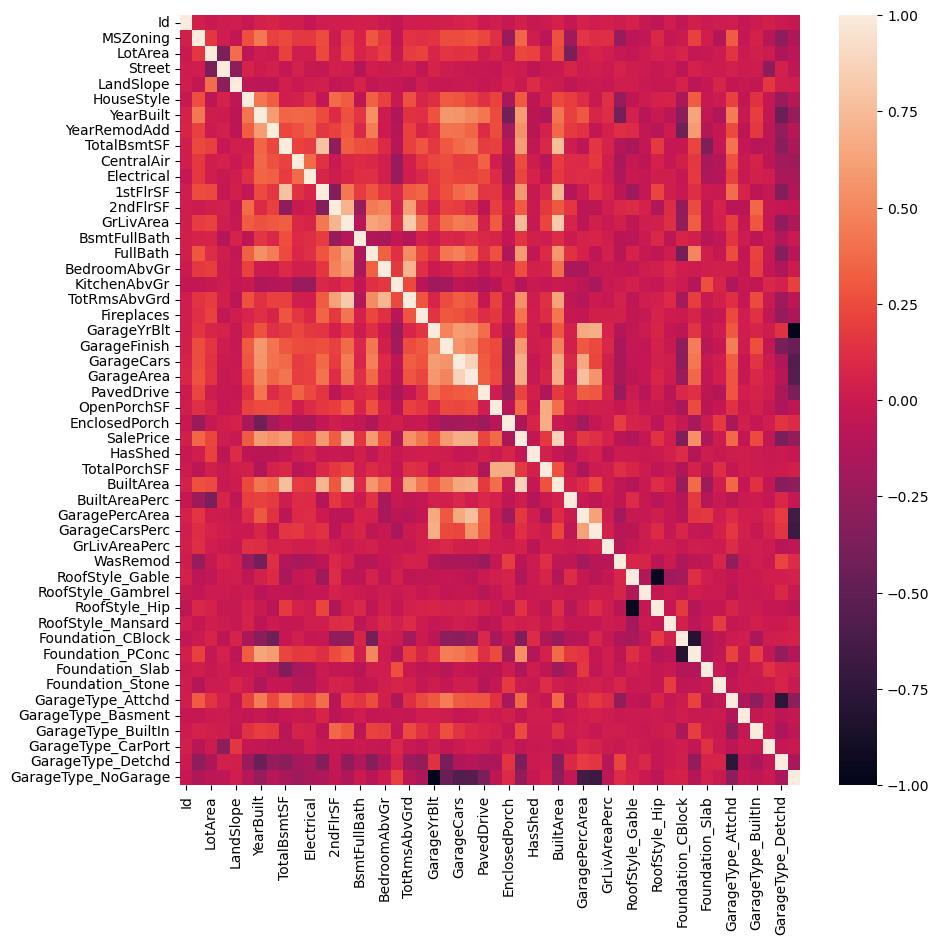

In [27]:
plt.figure(figsize=(10, 10))
corrs = df.corr(numeric_only=True)
sns.heatmap(corrs, vmin=-1, vmax=1)
plt.show()

In [28]:
import numpy as np

# Check high correlations, ignoring same feature and only taking the diagonal

corrs.where(np.triu(np.ones(corrs.shape), k=1).astype(bool)).unstack().dropna().abs().sort_values(ascending=False).head(20)

GarageType_NoGarage  GarageYrBlt          0.998661
RoofStyle_Hip        RoofStyle_Gable      0.953716
BuiltArea            SalePrice            0.873472
GarageArea           GarageCars           0.872321
TotRmsAbvGrd         GrLivArea            0.826289
BuiltArea            GrLivArea            0.822060
Foundation_PConc     Foundation_CBlock    0.804806
1stFlrSF             TotalBsmtSF          0.788664
GarageType_Detchd    GarageType_Attchd    0.764371
GaragePercArea       GarageArea           0.758524
BuiltArea            TotalBsmtSF          0.757839
SalePrice            GrLivArea            0.742650
BuiltArea            1stFlrSF             0.716421
TotRmsAbvGrd         BedroomAbvGr         0.712504
GrLivArea            2ndFlrSF             0.703236
GarageType_NoGarage  GarageCarsPerc       0.687340
GarageCarsPerc       GarageYrBlt          0.685200
SalePrice            GarageCars           0.683439
BuiltArea            GarageArea           0.678940
TotalPorchSF         EnclosedPo

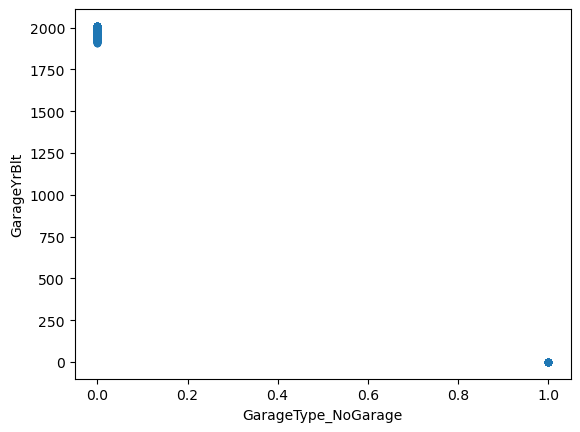

In [29]:
df.plot.scatter(x='GarageType_NoGarage', y='GarageYrBlt')
plt.show()

Drop `GarageType_NoGarage` because of very high correlation.

In [30]:
df.drop(columns=['GarageType_NoGarage'], inplace=True)

## Save New Dataset

In [ ]:
df.to_csv('data/house_pricing/house_pricing_prepared.csv', index=False)